**Universidad de Ingeniería  y Tecnología (UTEC)**  
Lima, Peru

# Tema de Laboratorio: Classification

**Alumnos**:

1. Leonardo Matías Candio Ormeño

1. Jeffry Hilario Quintana

1. Mauricio Alvarez Julca

## Find a publicly available dataset between 3 and 10 classes, with no more than 1000000 data points, and no less than 1000 data points. You can not use MNIST, but can use derivatives (you can use datasets other than images)

We chose to use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for this project  

## Define your Training Set, Your Validation Set, and Testing Set. How will you partition your data? What is the percentile split? (Example: 80% Training, 10% Validation, 10% Testing) Why did you pick this split

CIFAR-10 provides 50000 specific training images and 10000 testing images. We have also decided to randomly choose 500 images per class to use as our validation set. As a result, the percentage split is 75% training, 16.6% testing and 8.3% validation. 

The reason for the reduced size of the validation set comes down to the necessity for our training set to be as big as possible. 


In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

validation_per_label = 500

validation = {_label: set(np.random.permutation(np.arange(1, 5001))[:validation_per_label].flatten()) for _label
              in range(10)}
train = {_label: {_img for _img in [i for i in range(1, 5001)] if _img not in validation[_label]} for _label in
         range(10)}
test = {_label: {_img for _img in range(1, 1001)} for _label in range(10)}

In [0]:
def image_sets(img_type):
    def get_sets():

        _validation_set = []
        _train_set = []
        _test_set = []

        for key, value in validation.items():
            for number in value:
                _validation_set.append((key, number))

        for key, value in train.items():
            for number in value:
                _train_set.append((key, number))

        for key, value in test.items():
            for number in value:
                _test_set.append((key, number))

        random.shuffle(_validation_set)
        random.shuffle(_train_set)
        random.shuffle(_test_set)

        return _train_set, _validation_set, _test_set

    def load_img(_img_label, _img_position, _img_type):
        data_labels = {
            0: "airplane",
            1: "automobile",
            2: "bird",
            3: "cat",
            4: "deer",
            5: "dog",
            6: "frog",
            7: "horse",
            8: "ship",
            9: "truck",
        }
        data_path = "../data"
        return np.array(Image.open(
            f'{data_path}/{"train" if _img_type in ["validation", "train"] else "test"}/{data_labels[_img_label]}/{_img_position:04d}.png')), _img_label

    train_set, validation_set, test_set = get_sets()
    match img_type:
        case "train":
            for _img in train_set:
                yield load_img(*_img, "train")
        case "test":
            for _img in test_set:
                yield load_img(*_img, "test")
        case "validation":
            for _img in validation_set:
                yield load_img(*_img, "validation")
        case _:
            raise ValueError("img_type can only be validation, train or test")



3


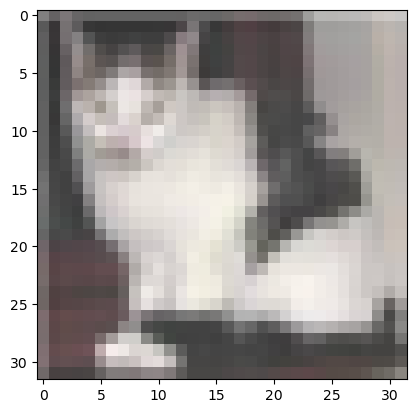

In [9]:
for img, label in image_sets("train"):
    plt.imshow(img)
    print(label)
    break